In [1]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt

Welcome to JupyROOT 6.11/01


In [2]:
def smear(xt):
  xeff = 0.3 + (1.0-0.3)/20*(xt+10.0)  #  efficiency                                                                                  
  x = ROOT.gRandom.Rndm()
  if x>xeff: return None
  xsmear = ROOT.gRandom.Gaus(-2.5,0.2)     #  bias and smear 
  return xt + xsmear

Let's start with the pyroot function. 

This is trained with a Breit-Wigner, mean 0.3 and width 2.5.     

In [3]:
class Response:
    def __init__(self, nb, xlo, xhi):
        self.measured = ROOT.TH1D("measured","measured",nb, xlo, xhi)
        self.truth = ROOT.TH1D("truth","truth",nb, xlo, xhi)
        self.response = ROOT.TH2D("Response","Response",nb, xlo, xhi, nb, xlo, xhi)
    def Fill(self, xr, xt):
        self.measured.Fill(xr)
        self.truth.Fill(xt)
        self.response.Fill(xr, xt)
    def Miss(self, xt):
        self.truth.Fill(xt)

In [4]:
response = Response(40, -10.0, 10.0)
for i in xrange(100000):
  xt = ROOT.gRandom.BreitWigner(0.3, 2.5)
  x = smear(xt)
  if x!=None:
    response.Fill(x, xt)
  else:
    response.Miss(xt)

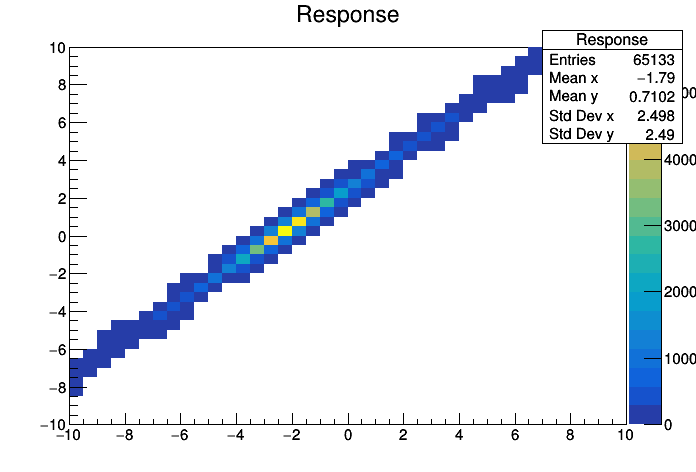

In [5]:
R = response.response
c1 = ROOT.TCanvas()
R.Draw("colz")
c1.Draw()

In [6]:
def smear_np(xt):
    xeff = 0.3 + (1.0-0.3)/20*(xt+10.0)
    if np.random.rand()>xeff: return None
    xsmear = np.random.normal(-2.5,0.2)     #  bias and smear 
    return xt + xsmear

In [7]:
class NP_Response:
    def __init__(self, truth, responsex, responsey, nbins, xlo, xhi):
        self.truth = np.histogram(truth, bins = nbins, range = (xlo,xhi))
        self.measured = np.histogram(responsex, bins = nbins, range = (xlo,xhi))
        self.response = np.histogram2d(responsex, responsey, bins = nbins, range = [[xlo,xhi],[xlo,xhi]])

In [8]:
truth = []
responsex = []
responsey = []
for i in xrange(100000):
  xt = ROOT.gRandom.BreitWigner(0.3, 2.5)
  x = smear(xt)
  if x!=None:
    responsex.append(x)
    responsey.append(xt)
  else:
    truth.append(xt)
    
new_response = NP_Response(truth, responsex, responsey, 40, -10., 10.)

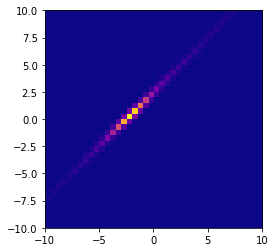

In [9]:
H, xedges, yedges = new_response.response
plt.imshow(H.T, interpolation='nearest', origin='low',
         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],cmap="plasma")
plt.show()

### Iterative code

Using the response matrix we trained earlier using a breit-wigner distribution. We can now test with a gaussian.

In [10]:
def array_from_TH1(th1):
    a = np.zeros(th1.GetNbinsX())
    nbins = th1.GetNbinsX()
    xlo = th1.GetXaxis().GetBinLowEdge(1)
    xhi = th1.GetXaxis().GetBinUpEdge(nbins)
    for i in range(1,th1.GetNbinsX()):
        a[i-1] = th1.GetBinContent(i)
    return a, nbins, xlo, xhi

In [11]:
hTrue = ROOT.TH1D ("true", "Test Truth",    40, -10.0, 10.0);
hMeas = ROOT.TH1D ("meas", "Test Measured", 40, -10.0, 10.0);
#  Test with a Gaussian, mean 0 and width 2.                                                                                          
for i in xrange(10000):
    xt = ROOT.gRandom.Gaus (0.0, 2.0)
    x = smear (xt);
    hTrue.Fill(xt);
    if x != None: hMeas.Fill(x);

10000.0 6506.0


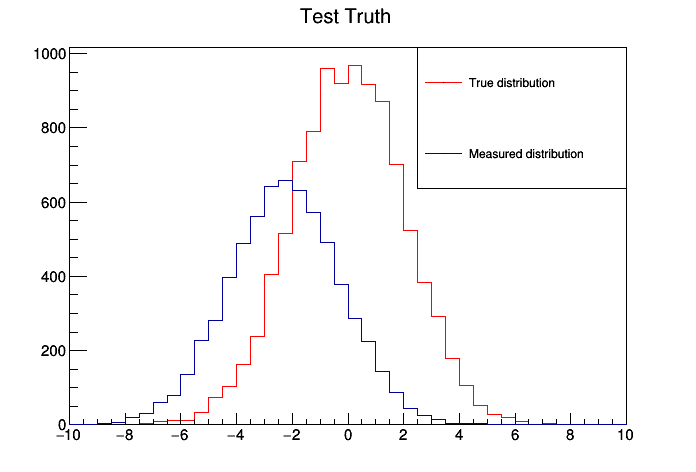

In [12]:
print hTrue.GetEntries(), hMeas.GetEntries()

c1 = ROOT.TCanvas()
hTrue.SetStats(0)
hTrue.SetLineColor(2)
hTrue.Draw()
hMeas.Draw("same")

leg = ROOT.TLegend(0.6, 0.6, 0.9, 0.9)
leg.AddEntry(hTrue, "True distribution","pl")
leg.AddEntry(hMeas, "Measured distribution", "pl")
leg.Draw()
c1.Draw()

In [13]:
npMeas, nbins, xlo, xhi = array_from_TH1(hMeas)
npTrue, nbins, xlo, xhi = array_from_TH1(hTrue)

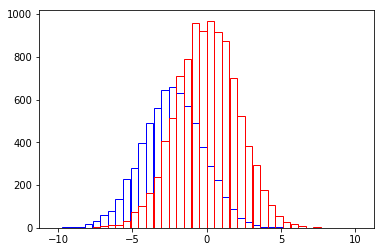

In [14]:
rang = np.linspace(xlo, xhi, nbins)
width = (xhi-xlo)/nbins
plt.bar(rang, npMeas, fill=False, edgecolor='blue', width=width)
plt.bar(rang, npTrue, fill=False, edgecolor='red', width=width)
plt.show()

In [15]:
class UnfoldIterative:
    def __init__(self, response, measured, niterations):
        self.response = response
        self.measured = measured
        self.niterations = niterations
        self.unfolded = False
        self.nm = response.measured.GetNbinsX()
        self.nt = response.truth.GetNbinsX()

    def unfold(self):
        mu = ROOT.TVectorD(self.nt)
        p = ROOT.TVectorD(self.nt)
        ntot = self.measured.Integral()
        for i in range(self.nt):
            p[i] = 1./self.nt
            mu[i] = ntot/self.nt
            
        epsilons = ROOT.TVectorD(self.nt)
        self.reco = self.response.truth.Clone()
        response = self.response.response

        for j in range(self.nm):
            observed_anywhere = 0.0
            for i in range(self.nt):
                observed_anywhere += response.GetBinContent(i,j)
            epsilons[j] = observed_anywhere/self.response.truth.GetBinContent(j)

        for iteration in range(self.niterations):
            for i in range(1,self.nt+1):    # which bin in the reco distribution
                sumoverj = 0.0
                sumofmus = 0.0
                for j in range(1,self.nm+1):
                    sumoverk = 0.0
                    for k in range(1,self.nt+1):
                        sumoverk += response.GetBinContent(j,k)*p[k-1]
                    if sumoverk > 0: 
                        sumoverj += self.measured.GetBinContent(j)*response.GetBinContent(j,i)*p[i-1]/sumoverk
                    else: sumoverj += 0.0
                mu[i-1] = sumoverj/epsilons[i-1]
                

            mutot = 0.0
            for j in range(self.nt):
                mutot += mu[j]
            for j in range(self.nt):                
                p[j] = mu[j]/mutot

        for i in range(1,self.nt+1):
            self.reco.SetBinContent(i,mu[i-1])
            
        self.unfolded = True

    def Hreco(self):
        if self.unfolded: return self.reco
        else:
            self.unfold()
            return self.reco

So let's copy this function!

In [16]:
class PynfoldIterative:
    def __init__(self, response, measured, niterations):
        #self.response, xedges, yedges = response.response
        self.response = response
        _, xedges, yedges = response.response
        self.measured = measured
        self.niterations = niterations
        self.unfolded = False
        self.nm = len(xedges) - 1
        self.nt = len(yedges) - 1

    def unfold(self):
        mu = [self.measured.sum()/self.nt for i in range(self.nt)]
        p = [1./self.nt for i in range(self.nt)]
            
        epsilons = ROOT.TVectorD(self.nt)
        response,_,_ = self.response.response
        truth, _ = self.response.truth
        epsilons = [response[i,:].sum()/truth[i] for i in range(self.nt)]
        measured = self.measured
        for iteration in range(self.niterations):
            for i in range(self.nt):    # which bin in the reco distribution
                sumoverj = 0.0
                for j in range(self.nm):
                    sumoverk = np.asarray([response[j,k]*p[k] for k in range(self.nt)]).sum()
                    if sumoverk > 0: 
                        sumoverj += measured[j]*response[j,i]*p[i]/sumoverk
                    else: sumoverj += 0.0
                mu[i] = sumoverj/epsilons[i] if epsilons[i] > 0 else 0
            for j in range(self.nt):                
                p[j] = mu[j]/np.asarray(mu).sum() if np.asarray(mu).sum() > 0 else 0.

            self.reco = mu

    def Hreco(self):
        if self.unfolded: return self.reco
        else:
            self.unfold()
            return self.reco

In [17]:
new_unfold = PynfoldIterative(new_response, npMeas, 4)

In [18]:
npMeas[1]

2.0

In [19]:
new_reco = new_unfold.Hreco()

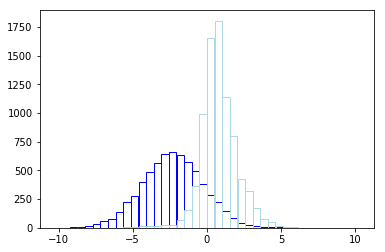

In [20]:
rang = np.linspace(xlo, xhi, nbins)
width = (xhi-xlo)/nbins
plt.bar(rang, npMeas, fill=False, edgecolor='blue', width=width)
plt.bar(rang, new_reco, fill=False, edgecolor='lightblue', width=width)
plt.show()